In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')
path_basic = 'drive/My Drive/gan_experiments'
os.chdir(path_basic)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import glob
from PIL import Image
import cv2
import numpy as np
import h5py
from tqdm import tqdm_notebook

import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import random

In [0]:
IMG_HEIGHT = 480
IMG_WIDTH = 640
IMG_CHANNELS = 3

In [0]:
root_dir = 'data/ISTD_Dataset/'

In [0]:
root_filename = os.path.join(root_dir, 'hdf5_dataset', 'data_istd.h5')
img_A_pathes = glob.glob(os.path.join(root_dir, 'train/train_A/*.*'))
img_B_pathes = glob.glob(os.path.join(root_dir, 'train/train_C/*.*'))
num_samples_A = len(img_A_pathes)
num_samples_B = len(img_B_pathes)
SHAPE_A = (num_samples_A,IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
SHAPE_B = (num_samples_B,IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

# placeholders
with h5py.File(root_filename, "w") as out:
  out.create_dataset("domain_A", SHAPE_A, dtype='u1')
  out.create_dataset("domain_B", SHAPE_B, dtype='u1')

In [70]:
# APPEND IMAGES TO THE FILE
with h5py.File(root_filename, "a") as out:
  for i,img_path in tqdm_notebook(enumerate(img_A_pathes), total=num_samples_A):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    out['domain_A'][i] = np.asarray(img)

In [71]:
# APPEND IMAGES TO THE FILE
with h5py.File(root_filename, "a") as out:
  for i,img_path in tqdm_notebook(enumerate(img_B_pathes), total=num_samples_B):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    out['domain_B'][i] = np.asarray(img)

### Write dataloader with hdf5

In [0]:
image_size=256

In [0]:
transforms_hdf = [
            transforms.ToPILImage(),
            transforms.Resize(int(image_size * 1.12), Image.BICUBIC),
            transforms.RandomCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

transforms_png = [
            transforms.Resize(int(image_size * 1.12), Image.BICUBIC),
            transforms.RandomCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

In [0]:
# timer utils
import time
import functools
def timer(f):
  @functools.wraps(f)
  def wrapper(*args, **kwargs):
    start_time = time.time()
    r = f(*args, **kwargs)
    duration = time.time() - start_time
    result = {
        'result':r,
        'time':duration
    }
    return result
  return wrapper

In [0]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.files_A = sorted(glob.glob(os.path.join(root, '%s/train_A' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%s/train_C' % mode) + '/*.*'))

    @timer
    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))
        item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [0]:
class ImageDatasetHDF5(Dataset):
    def __init__(self, path_hdf5, transforms_=None):
        self.transform = transforms.Compose(transforms_)
        self.files = h5py.File(path_hdf5, "r")
        self.domain_A = 'domain_A'
        self.domain_B = 'domain_B'

        self.length_A = self.files[self.domain_A].shape[0]
        self.length_B = self.files[self.domain_B].shape[0]

    @timer
    def __getitem__(self, index):
        item_A = self.transform(self.files[self.domain_A][index % self.length_A])
        item_B = self.transform(self.files[self.domain_B][random.randint(0, self.length_B - 1)])
        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(self.length_A, self.length_B)

In [0]:
data_hdf5 = ImageDatasetHDF5(root_filename, transforms_=transforms_hdf)
data_png = ImageDataset(root_dir, transforms_=transforms_png)

In [0]:
dataloader_hdf5 = DataLoader(data_hdf5,batch_size=1, shuffle=True, num_workers=1)
dataloader_png = DataLoader(data_png,  batch_size=1, shuffle=True, num_workers=1)

In [127]:
time_hdf5 = []
for i, _batch in tqdm_notebook(enumerate(dataloader_hdf5), total=100):
  batch = _batch['result']
  time_batch = _batch['time']
  time_hdf5.append(time_batch)

time_png = []
for i, _batch in tqdm_notebook(enumerate(dataloader_png), total=100):
  batch = _batch['result']
  time_batch = _batch['time']
  time_png.append(time_batch)

In [0]:
time_png = np.array(time_png)
time_hdf5 = np.array(time_hdf5)

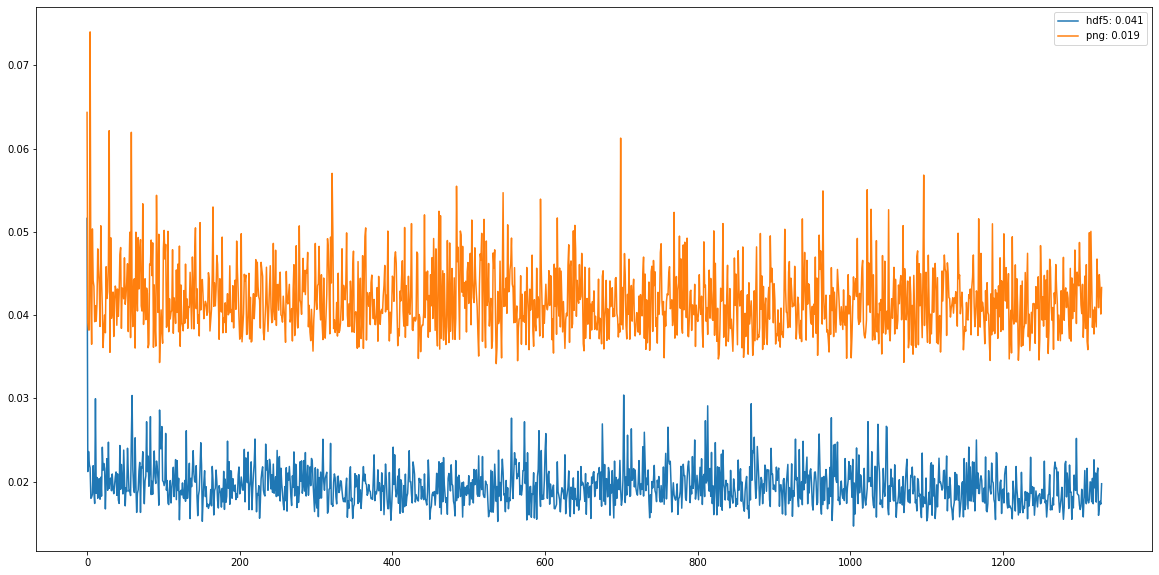

In [129]:
mean_hdf5 = np.median(time_png)
mean_png = np.median(time_hdf5)

plt.subplots(figsize=(20,10))
plt.plot(time_hdf5, label=f'hdf5: {mean_hdf5:.3f}')
plt.plot(time_png, label=f'png: {mean_png:.3f}')

plt.legend();